In [5]:
import pandas as pd 

In [6]:
#find df at https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction
df = pd.read_csv("fake_job_postings.csv", index_col='job_id')

Define ML problems



    [ ] Choose your target. Which column in your tabular dataset will you predict?
     - I will be predicting the fraudulent column
    [ ] Is your problem regression or classification?
     - Classification
    [ ] How is your target distributed?
        Classification: How many classes? Are the classes imbalanced?
           - 2, it is binary, and heavily imbalanced. The majority class is 95%
    [ ] Choose your evaluation metric(s).
        Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
        - Recall is what I'll be using.

    [ ] Choose which observations you will use to train, validate, and test your model.
        Are some observations outliers? Will you exclude them?
            - I would like to use all of them to TVT.
        Will you do a random split or a time-based split?
            - random
    [ ] Begin to clean and explore your data.
    [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?


Day One: Spent tutorialing text parsing so I can get metrics from heavy text data.

I noticed most fraudulents have a lot of NaN's 
 - If row has more than 8 NaN's - assume it is fraudulent is a good guess

In [167]:
df

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,missing_data
job_id,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,4
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,2
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,8
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,1
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,2
17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,1
17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0,7


In [8]:
df['fraudulent'].value_counts(normalize=True)

0    0.951566
1    0.048434
Name: fraudulent, dtype: float64

In [29]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [14]:
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                                stratify= df['fraudulent'], random_state=3)

In [21]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                                stratify= train['fraudulent'], random_state=3)

In [22]:
train.shape, val.shape, test.shape

((11443, 17), (2861, 17), (3576, 17))

In [144]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    missing_data = []
    for i in range(len(X)) :
        missing_data.append(X.iloc[i].isnull().sum())
    X['missing_data'] = missing_data
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)



In [148]:
%matplotlib inline
import matplotlib.pyplot as plt


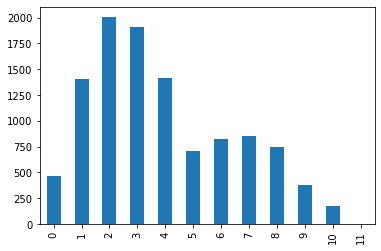

In [165]:
onlyfraud = train[train['fraudulent'] == 1]
notfraud = train[train['fraudulent'] == 0]
fake = pd.Series(notfraud['missing_data'].value_counts().sort_index())

fake.plot.bar();

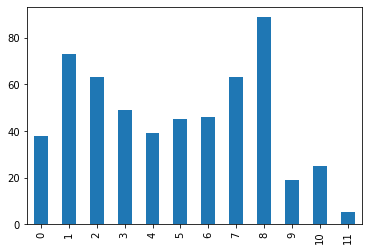

In [166]:
fake2 = pd.Series(onlyfraud['missing_data'].value_counts().sort_index())

fake2.plot.bar();